<a href="https://colab.research.google.com/github/panks11/CE888/blob/main/labs/lab3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.preprocessing import OneHotEncoder as en
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, confusion_matrix,SCORERS,accuracy_score as acc,f1_score,recall_score
from sklearn.dummy import DummyClassifier
import numpy as np
import itertools

## Data Loading

In [102]:
bank_df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv',delimiter=';')

In [103]:
# ~Check Data Loading is correct
bank_df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [104]:
bank_df.info()
# Observations 
  # 20 Features / Attribute input columns , Output variable 'y' with 41188 rows 
  # The columns do not contain non null values based on non-null Count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [105]:
# Summary of Numerical attributes 
bank_df.describe().transpose()
# 75% people are below 47 of Age


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


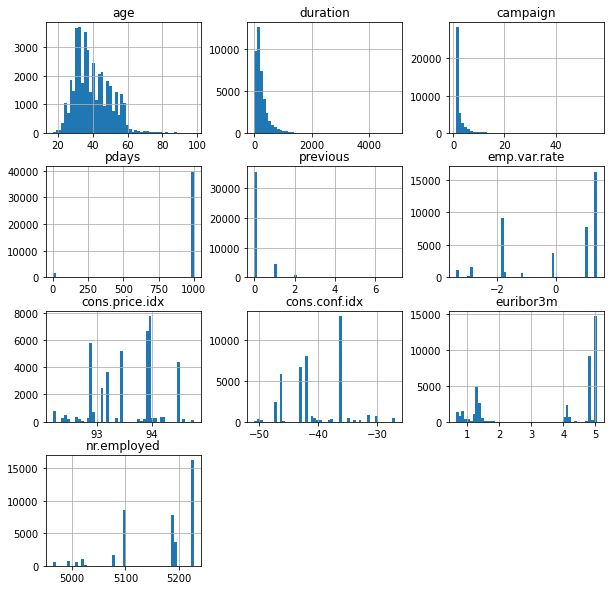

In [106]:
#Visualizing Dataset
bank_df.hist(bins=50,figsize=(10,10))
plt.show()

# attributes have different scales
# campaign and duration are right skewed

In [107]:
#Checking values in previous and emp.var.rate as they look discrete in the above graph
print(bank_df['previous'].value_counts())
print(bank_df['emp.var.rate'].value_counts())

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64
 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: emp.var.rate, dtype: int64


## Data preprocessing:





## Plot histogram of the label and calculate the imbalance in the dataset.

In [108]:
# Checking the Data balance
print("The dataset is imbalanced as the ~89% of the data set belongs to 'yes' category and only ~11% belongs to 'no category")
bank_df['y'].value_counts()

The dataset is imbalanced as the ~89% of the data set belongs to 'yes' category and only ~11% belongs to 'no category


no     36548
yes     4640
Name: y, dtype: int64

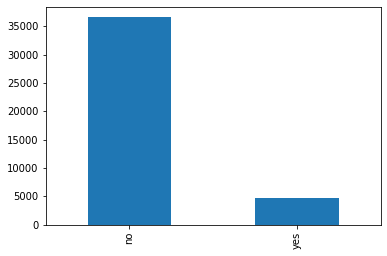

In [109]:
# Visualize using Histogram
bank_df['y'].value_counts().plot(kind='bar')

In [110]:
bank_df['y_temp'] = bank_df['y'].replace({'no':0,'yes':1})
corr = bank_df.corr()
corr.style.background_gradient(cmap='PuBu')


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_temp
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


In [111]:
bank_df.drop('y_temp',axis=1,inplace=True)

Dropping Duration

In [112]:
bank_df.drop('duration',axis=1,inplace=True)
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Checking the values in Categorical Features

In [113]:
cat_features = ['job', 
            'marital', 
            'education', 
            'default', 
            'housing', 
            'loan',
            'contact', 
            'month', 
            'day_of_week',
            'poutcome']

In [114]:
for feature in cat_features:
  print(10*'*',feature,10*'*')
  print(bank_df[feature].value_counts())

********** job **********
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
********** marital **********
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
********** education **********
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
********** default **********
no         32588
unknown     8597
yes            3
Name: default, dtype: int64
********** housing **********
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64
********** loan **********
no   

Handling Categorical Variables

In [115]:
df_dummies = pd.get_dummies(bank_df)

In [116]:
df_dummies.columns


Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_s

In [117]:
df_dummies = df_dummies.rename(columns = {'y_yes':'y'})
df_dummies.drop('y_no',axis=1,inplace=True)
df_dummies['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [118]:
train, test = train_test_split(df_dummies, test_size=0.2, random_state=50,stratify=df_dummies['y'])  

In [119]:
# split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=50)

# for train_i,test_i in split.split(bank_df,bank_df['y']):
#   train = bank_df.loc[train_i]
#   test = bank_df.loc[test_i]

In [120]:
# Check ratio of the samples in Test and train sample
print("Training Shape {} and %".format(train.shape))
print(train['y'].value_counts()/len(train))
print("Test shape {} and %".format(test.shape))
print(test['y'].value_counts()/len(test))

Training Shape (32950, 63) and %
0    0.887344
1    0.112656
Name: y, dtype: float64
Test shape (8238, 63) and %
0    0.887351
1    0.112649
Name: y, dtype: float64


In [121]:
X_train = train.drop('y',axis=1)
y_train = train['y'].copy()

In [122]:
X_test = test.drop('y',axis=1)
y_test = test['y'].copy()

## Use LabelEncoder to convert the label into numbers.

In [123]:
label_encoder = LabelEncoder()
y_train_processed = label_encoder.fit_transform(y_train)

Handling Numeric Values

In [124]:
num_features = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

In [125]:
colTransformer = ColumnTransformer([("num",StandardScaler(),num_features),],remainder='passthrough')

In [126]:
X_train_processed  = colTransformer.fit_transform(X_train)
X_train_processed[0,:]

array([-1.72917814,  0.15624845, -5.17551625,  1.68199284, -2.21626217,
       -1.97491842,  2.93585685, -1.66734612, -2.07125007,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ])

In [127]:
print( sorted(SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 'v_measure_score']


In [128]:
clf = RandomForestClassifier(n_estimators=100,max_depth=3)
scores = cross_val_score(clf, X_train_processed, y_train_processed, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.90 +/- 0.00


In [129]:
clf.fit(X_train_processed, y_train_processed)

RandomForestClassifier(max_depth=3)

## Classification Report

In [130]:
from sklearn.metrics import classification_report

In [131]:
X_test_processed = colTransformer.transform(X_test)

In [132]:
y_test_processed = label_encoder.transform(y_test)

In [133]:
y_pred_test = clf.predict(X_test_processed)

In [134]:
print(confusion_matrix(y_test_processed, y_pred_test))

[[7257   53]
 [ 784  144]]


In [135]:
print(classification_report(y_test_processed, y_pred_test))

# Precision (cat 0: not subscribed):We can see out of 8036 predictions for 'Label 0' 7250 were correct {columnwises}
# Recall (cat 1: subscribed):We can see 72580 out of 7310 non subscribers were predicted correctly {rowise}

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      7310
           1       0.73      0.16      0.26       928

    accuracy                           0.90      8238
   macro avg       0.82      0.57      0.60      8238
weighted avg       0.88      0.90      0.87      8238



In [136]:
f1_score(y_test_processed, y_pred_test)

0.256

# Choosing F1 score as metrics due to imbalanced dataset

The predictions when the non-subscribers categorized as subscribers by the model should be low as we would loose potential prospects due to wrong predictions. 



In [137]:
clf = RandomForestClassifier(n_estimators=100,max_depth=3)
scores = cross_val_score(clf, X_train_processed, y_train_processed, cv=10, scoring=make_scorer(f1_score))  # cross-validation
print("f1_score Score: %.2f +/- %.2f" % (scores.mean(), scores.std()))
train_score = scores.mean()

f1_score Score: 0.23 +/- 0.05


In [138]:
clf.fit(X_train_processed, y_train_processed)

RandomForestClassifier(max_depth=3)

In [139]:
y_pred_test = clf.predict(X_test_processed)
print(confusion_matrix(y_test_processed, y_pred_test))

[[7245   65]
 [ 757  171]]


Comparison with Dummy Classifier

In [140]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train_processed, y_train_processed)
y_pred_test_dummy = dummy_clf.predict(X_test_processed)
print(confusion_matrix(y_test_processed, y_pred_test_dummy))

[[6464  846]
 [ 826  102]]


In [141]:
print(classification_report(y_test_processed, y_pred_test_dummy))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7310
           1       0.11      0.11      0.11       928

    accuracy                           0.80      8238
   macro avg       0.50      0.50      0.50      8238
weighted avg       0.80      0.80      0.80      8238



The Dummy classifier is not very less f1 score at classifying 

## GridSearch

In [142]:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {
                  'n_estimators': [3, 10, 30], 
                  'max_features': [2, 4, 6, 8]
               },
              {
                  'bootstrap': [False], 
                  'n_estimators': [3, 10], 
                  'max_features': [2, 3, 4]
              }
              ]
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,scoring=make_scorer(f1_score),return_train_score=True)
print(grid_search.fit(X_train_processed, y_train_processed))
print(grid_search.best_params_)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring=make_scorer(f1_score))
{'max_features': 8, 'n_estimators': 30}


In [143]:
from sklearn.model_selection import GridSearchCV
param_grid = [
              {
                  'n_estimators': [3], 
                  'max_features': [4],
                  'criterion': ['entropy'],
                  'min_samples_leaf': [80, 100],
                  'max_depth': [25, 27],
                  'min_samples_split': [3, 5]
                }
              
              ]
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,scoring=make_scorer(f1_score),return_train_score=True)
print(grid_search.fit(X_train_processed, y_train_processed))
print(grid_search.best_params_)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy'], 'max_depth': [25, 27],
                          'max_features': [4], 'min_samples_leaf': [80, 100],
                          'min_samples_split': [3, 5], 'n_estimators': [3]}],
             return_train_score=True, scoring=make_scorer(f1_score))
{'criterion': 'entropy', 'max_depth': 27, 'max_features': 4, 'min_samples_leaf': 80, 'min_samples_split': 3, 'n_estimators': 3}


In [144]:
grid_search.best_score_

0.25072410347813123

In [145]:
final_model = grid_search.best_estimator_

## Feature Importance

In [146]:
importances = final_model.feature_importances_

In [147]:
k = np.argsort(importances)[::-1]

In [148]:
indices=k[:10]

In [149]:
importances[indices]

array([0.33817583, 0.15886727, 0.13722495, 0.08450094, 0.05991149,
       0.05697741, 0.02449797, 0.02149818, 0.01189703, 0.0110437 ])

Feature ranking:
1. emp.var.rate (0.338176)
2. nr.employed (0.158867)
3. cons.conf.idx (0.137225)
4. previous (0.084501)
5. contact_cellular (0.059911)
6. cons.price.idx (0.056977)
7. month_may (0.024498)
8. euribor3m (0.021498)
9. job_student (0.011897)
10. campaign (0.011044)


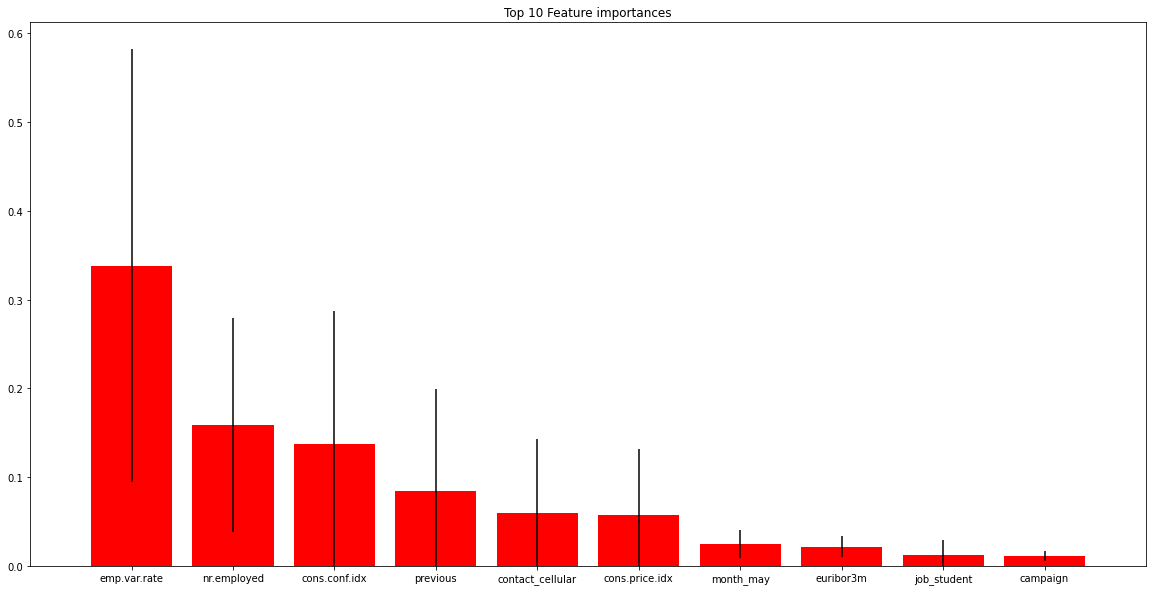

In [150]:
feat_names=X_train.columns
X = X_train_processed
std = np.std([tree.feature_importances_ for tree in final_model.estimators_],axis=0)
# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Top 10 Feature importances")
# plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(10), np.array(feat_names)[indices])
plt.xlim([-1, 10])
plt.ylim([0, None])

fig.set_size_inches(20,10)

Generalization Error

In [151]:
final_model.fit(X_train_processed, y_train_processed)
y_pred_test = final_model.predict(X_test_processed)
y_pred_train = final_model.predict(X_train_processed)
test_score = recall_score(y_test_processed, y_pred_test)

print('Score on Unseen  Data',test_score)
print('Score on Training Data',train_score)
print('Error',train_score-test_score)

Score on Unseen  Data 0.19827586206896552
Score on Training Data 0.23444971472503967
Error 0.036173852656074146


### Confusion Matrix

In [152]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


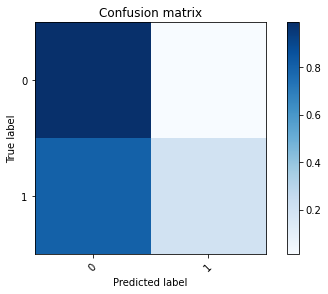

In [153]:
c = confusion_matrix(y_test_processed, y_pred_test)
plot_confusion_matrix(c, label_encoder.classes_)

### Train with SMOTE 

Trying to generate synthetic sample for Minority Class.

Ref : https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class.

In [154]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import make_scorer,f1_score


In [155]:
bank_df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv',delimiter=';')
bank_df.drop('duration',axis=1,inplace=True)
df_dummies = pd.get_dummies(bank_df)

df_dummies = df_dummies.rename(columns = {'y_yes':'y'})
df_dummies.drop('y_no',axis=1,inplace=True)
df_dummies['y'].value_counts()

train, test = train_test_split(df_dummies, test_size=0.2, random_state=50,stratify=df_dummies['y'])  


X_train = train.drop('y',axis=1)
y_train = train['y'].copy()

X_test = test.drop('y',axis=1)
y_test = test['y'].copy()


In [156]:
y_train.value_counts()

0    29238
1     3712
Name: y, dtype: int64

In [157]:
# from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek as SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [158]:
y_res.value_counts()

1    29161
0    29161
Name: y, dtype: int64

In [159]:
clf = RandomForestClassifier(n_estimators=80,max_depth=10,criterion='entropy')
scores = cross_val_score(clf, X_res, y_res, cv=10, scoring=make_scorer(f1_score))  # cross-validation
print("f1 score: %.2f +/- %.2f" % (scores.mean(), scores.std()))

f1 score: 0.83 +/- 0.06


In [160]:
clf.fit(X_res,y_res)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80)

In [161]:
yred = clf.predict(X_test)

In [162]:
print(f1_score(y_test,yred))
print(f1_score(clf.predict(X_res),y_res))

0.5043062200956937
0.8378209372471125


In [163]:
clf.n_features_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


62

In [164]:
test.to_csv('testset.csv',index=False)

In [165]:
test.shape

(8238, 63)

### Quiz

In [166]:
# import pickle as pkl
# outp = open('model.pkl', 'wb')
# pkl.dump(clf, outp, -1)  # where clf is your classifier
# outp.close()

In [167]:
# import numpy as np
# from sklearn.metrics import f1_score
# import pickle as pkl
# import pandas as pd
# import os, contextlib
# import warnings

# warnings.filterwarnings("ignore")

# with open(os.devnull, 'w') as devnull:
#     with contextlib.redirect_stdout(devnull):
#         inp = open('model.pkl', 'rb')
#         clf = pkl.load(inp)
#         inp.close()
#         testset = pd.read_csv('testset.csv')

# x, y = testset.drop(labels=['y'], axis=1, inplace=False), testset['y']
# y_pred = clf.predict(x)
# f1 = f1_score(y, y_pred)
# print("F1-score on test set:", f1)

In [168]:
# clf = RandomForestClassifier(n_estimators=1000 ,max_depth=8,random_state=60)
# scores = cross_val_score(clf, X_train_processed, y_train_processed, cv=10, scoring=make_scorer(f1_score))  # cross-validation
# print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))

In [169]:
# clf.fit(X_train_processed, y_train_processed)

In [170]:
# X_test_processed = colTransformer.transform(X_test)

In [171]:
# y_test_processed = label_encoder.transform(y_test)

In [172]:
# y_pred_test = clf.predict(X_test_processed)

In [173]:
# f1_score(y_test_processed, y_pred_test)   

In [175]:
# final_model = RandomForestClassifier(n_estimators=300,max_depth=12,random_state=60)
# final_model.fit(X_train_processed, y_train_processed)
# importances = final_model.feature_importances_
# k = np.argsort(importances)[::-1]
# indices=k[:10]
# feat_names=X_train.columns
# X = X_train_processed
# std = np.std([tree.feature_importances_ for tree in final_model.estimators_],axis=0)
# # Print the feature ranking
# print("Feature ranking:")
# for f in range(10):
#     print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# # Plot the feature importances of the forest
# fig = plt.figure()
# plt.title("Top 10 Feature importances")
# # plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(10), np.array(feat_names)[indices])
# plt.xlim([-1, 10])
# plt.ylim([0, None])

# fig.set_size_inches(20,10)